
# Geo-Temporal Analysis: Sub-State / Route-Level Insights

In this notebook, we extend our previous analysis by drilling down to 
sub-state details. We aim to:
1. Identify the municipality (sub-state region) in which each seller 
   and customer resides.
2. Group or aggregate shipping metrics (e.g., delivery times, lateness) 
   by municipality or by seller→customer route.
3. Visualize the results using *geobr* for Brazilian municipality 
   boundaries, providing deeper insight into **local** shipping bottlenecks 
   or routes with the highest delays.


## Libraries & Setup


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import geobr
import imageio

# Display plots inline
%matplotlib inline

# Set a consistent style for plots
sns.set_style("whitegrid")

print("Libraries imported successfully!")


Libraries imported successfully!


**Explanation**:
- `pandas` for DataFrame manipulation
- `geopandas` for geospatial data handling
- `geobr` to fetch official Brazilian municipality polygons
- `matplotlib` & `seaborn` for plotting
- `geopy.distance.geodesic` for distance calculations between lat/long points


## Data Loading & Merging


In [2]:
# Read CSV files
orders_df = pd.read_csv('../data/olist_orders_dataset.csv', parse_dates=[
    'order_purchase_timestamp',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
])
order_items_df = pd.read_csv('../data/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
customers_df = pd.read_csv('../data/olist_customers_dataset.csv')
sellers_df = pd.read_csv('../data/olist_sellers_dataset.csv')
geolocation_df = pd.read_csv('../data/olist_geolocation_dataset.csv')

print("DataFrames loaded:")
print(f"orders_df: {orders_df.shape}")
print(f"order_items_df: {order_items_df.shape}")
print(f"customers_df: {customers_df.shape}")
print(f"sellers_df: {sellers_df.shape}")
print(f"geolocation_df: {geolocation_df.shape}")


DataFrames loaded:
orders_df: (99441, 8)
order_items_df: (112650, 7)
customers_df: (99441, 5)
sellers_df: (3095, 4)
geolocation_df: (1000163, 5)


In [3]:
#Basic cleaning & geolocation aggregation
geolocation_df.rename(columns={
    'geolocation_zip_code_prefix': 'zip_prefix',
    'geolocation_lat': 'latitude',
    'geolocation_lng': 'longitude',
    'geolocation_city': 'city',
    'geolocation_state': 'state'
}, inplace=True)

# Drop duplicates if desired
geolocation_df.drop_duplicates(inplace=True)

# Aggregated geolocation: 1 row per zip_prefix
aggregated_geolocation = geolocation_df.groupby('zip_prefix', as_index=False).agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'state': lambda x: x.mode()[0] if not x.mode().empty else np.nan
})

# This gives one row per zip_prefix, with an aggregated lat/long
aggregated_geolocation.head()

,zip_prefix,latitude,longitude,city,state
0,1001,-23.550227,-46.634039,sao paulo,SP
1,1002,-23.547657,-46.634991,sao paulo,SP
2,1003,-23.549000,-46.635582,sao paulo,SP
3,1004,-23.549829,-46.634792,sao paulo,SP
4,1005,-23.549547,-46.636406,sao paulo,SP


**Explanation**:
1. **Data Reading**: We parse date columns in `orders_df` and `order_items_df`.
2. **Geolocation Aggregation**: Since Olist's `olist_geolocation_dataset` may have multiple lat/long entries for the same ZIP prefix, we aggregate them together by using its mode.



In [4]:
# Merge customers with aggregated geolocation
customers_agg = customers_df.merge(
    aggregated_geolocation,
    left_on='customer_zip_code_prefix',
    right_on='zip_prefix',
    how='left'
).rename(columns={'latitude': 'customer_lat', 'longitude': 'customer_lng'})

# Merge sellers with aggregated geolocation
sellers_agg = sellers_df.merge(
    aggregated_geolocation,
    left_on='seller_zip_code_prefix',
    right_on='zip_prefix',
    how='left'
).rename(columns={'latitude': 'seller_lat', 'longitude': 'seller_lng'})

# Merge order_items with orders
orders_items_merged = order_items_df.merge(orders_df, on='order_id', how='left')

# Merge sellers
orders_items_sellers = orders_items_merged.merge(sellers_agg, on='seller_id', how='left')

# Final merge with customers
full_df = orders_items_sellers.merge(customers_agg, on='customer_id', how='left', suffixes=('', '_cust'))

print("full_df shape:", full_df.shape)
full_df.head(3)

full_df shape: (112650, 31)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,zip_prefix_cust,customer_lat,customer_lng,city_cust,state_cust
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,RJ,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,28013.0,-21.763186,-41.310265,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,SP,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,15775.0,-20.222506,-50.898951,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,MG,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,35661.0,-19.869998,-44.593059,para de minas,MG


**Explanation**:
- **customers_agg** and **sellers_agg** each have lat/long columns for their respective ZIP prefixes.
- We do an incremental merge: (Order Items + Orders) → +Sellers → +Customers.
- `full_df` now has columns for:
  - **Timestamps** (purchase, delivered, etc.)
  - **Seller** lat/long
  - **Customer** lat/long
  - **Item**-level details like price, freight, etc.


## Calculate Time-Based Columns

In [5]:
#Create year_month from order_purchase_timestamp
full_df['year_month'] = full_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Calculate overall purchase to delivery
full_df['purchase_to_delivery_days'] = (
    full_df['order_delivered_customer_date'] - full_df['order_purchase_timestamp']
).dt.total_seconds() / (3600 * 24)

# Filter out invalid or missing times
full_df = full_df[
    (full_df['purchase_to_delivery_days'].notna()) &
    (full_df['purchase_to_delivery_days'] >= 0)
].copy()

# Optional: lateness vs. estimated
full_df['lateness_days'] = (
    full_df['order_delivered_customer_date'] - full_df['order_estimated_delivery_date']
).dt.total_seconds() / (3600 * 24)

# Check
full_df[['purchase_to_delivery_days','lateness_days']].describe()

,purchase_to_delivery_days,lateness_days
count,110196.000000,110196.000000
mean,12.472631,-11.333149
std,9.445655,10.162342
min,0.533414,-146.016123
25%,6.736262,-16.321042
50%,10.184282,-12.046788
75%,15.541097,-6.476803
max,209.628611,188.975081


**Explanation**:
- Negative or NaN time deltas can happen if the data has missing or reversed timestamps. We remove them for a cleaner analysis.
- `lateness_days` helps measure whether deliveries exceed their estimated date (`>0` is late, `<0` is early).


## Municipality Boundaries + Spatial Join


In [6]:
municipalities_gdf = geobr.read_municipality(year=2020)
municipalities_gdf = municipalities_gdf[['code_muni','name_muni','abbrev_state','geometry']].copy()

print("Municipalities gdf shape:", municipalities_gdf.shape)
municipalities_gdf.head(3)

Municipalities gdf shape: (5570, 4)


,code_muni,name_muni,abbrev_state,geometry
0,1100015.0,Alta Floresta D'oeste,RO,"MULTIPOLYGON (((-62.19465 -11.82746, -62.18945..."
1,1100023.0,Ariquemes,RO,"MULTIPOLYGON (((-62.53648 -9.73222, -62.52765 ..."
2,1100031.0,Cabixi,RO,"MULTIPOLYGON (((-60.37119 -13.36655, -60.37661..."



### Create GeoDataFrames for Sellers & Customers


In [7]:
sellers_sub = full_df[['seller_id','seller_lat','seller_lng']].drop_duplicates()
sellers_sub['geometry'] = gpd.points_from_xy(
    sellers_sub['seller_lng'],
    sellers_sub['seller_lat']
)
sellers_gdf = gpd.GeoDataFrame(sellers_sub, geometry='geometry', crs='EPSG:4326')

customers_sub = full_df[['customer_id','customer_lat','customer_lng']].drop_duplicates()
customers_sub['geometry'] = gpd.points_from_xy(
    customers_sub['customer_lng'],
    customers_sub['customer_lat']
)
customers_gdf = gpd.GeoDataFrame(customers_sub, geometry='geometry', crs='EPSG:4326')

**Explanation**:
- `geobr.read_municipality(year=2020)` returns a GeoDataFrame of all Brazilian municipalities.
- Key columns:
  - `code_muni`: A unique numeric IBGE code for each municipality.
  - `name_muni`: The municipality name.
  - `abbrev_state`: Two-letter state abbreviation.
  - `geometry`: Polygon or MultiPolygon describing the area.

### Match CRS and Spatially Join

In [8]:
# If municipalities_gdf is EPSG:4674, reproject sellers_gdf/customers_gdf:
if sellers_gdf.crs != municipalities_gdf.crs:
    sellers_gdf = sellers_gdf.to_crs(municipalities_gdf.crs)
    customers_gdf = customers_gdf.to_crs(municipalities_gdf.crs)

# Spatial join for sellers
sellers_with_muni = gpd.sjoin(
    sellers_gdf,
    municipalities_gdf,
    how='left',
    predicate='within'
).rename(columns={
    'code_muni': 'seller_code_muni',
    'name_muni': 'seller_name_muni',
    'abbrev_state': 'seller_state'
})

# Spatial join for customers
customers_with_muni = gpd.sjoin(
    customers_gdf,
    municipalities_gdf,
    how='left',
    predicate='within'
).rename(columns={
    'code_muni': 'customer_code_muni',
    'name_muni': 'customer_name_muni',
    'abbrev_state': 'customer_state'
})


In [9]:
# Merge seller muni info
seller_muni_info = sellers_with_muni[['seller_id','seller_code_muni','seller_name_muni','seller_state']].drop_duplicates()
full_df = pd.merge(full_df, seller_muni_info, on='seller_id', how='left')

# Merge customer muni info
customer_muni_info = customers_with_muni[['customer_id','customer_code_muni','customer_name_muni','customer_state']].drop_duplicates()
full_df = pd.merge(full_df, customer_muni_info, on='customer_id', how='left', suffixes=('', '_cust2'))

print("full_df shape (with municipality codes):", full_df.shape)
full_df.head(3)


full_df shape (with municipality codes): (110196, 40)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,state_cust,year_month,purchase_to_delivery_days,lateness_days,seller_code_muni,seller_name_muni,seller_state_y,customer_code_muni,customer_name_muni,customer_state_cust2
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,RJ,2017-09,7.614421,-8.011250,3306305.0,Volta Redonda,RJ,3301009.0,Campos Dos Goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,SP,2017-04,16.216181,-2.330278,3550308.0,São Paulo,SP,3554904.0,Três Fronteiras,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,MG,2018-01,7.948437,-13.444954,3108305.0,Borda Da Mata,MG,3147105.0,Pará De Minas,MG


In [10]:
print("All columns in full_df:")
for col in full_df.columns:
    print(col)


All columns in full_df:
order_id
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value
customer_id
order_status
order_purchase_timestamp
order_approved_at
order_delivered_carrier_date
order_delivered_customer_date
order_estimated_delivery_date
seller_zip_code_prefix
seller_city
seller_state_x
zip_prefix
seller_lat
seller_lng
city
state
customer_unique_id
customer_zip_code_prefix
customer_city
customer_state
zip_prefix_cust
customer_lat
customer_lng
city_cust
state_cust
year_month
purchase_to_delivery_days
lateness_days
seller_code_muni
seller_name_muni
seller_state_y
customer_code_muni
customer_name_muni
customer_state_cust2


In [11]:
# columns to drop
columns_to_drop = [
    'shipping_limit_date',
    'order_approved_at',
    'seller_zip_code_prefix',
    'zip_prefix',
    'city',
    'state',
    'customer_unique_id',
    'customer_zip_code_prefix',
    'customer_city',
    'customer_state',
    'zip_prefix_cust',
    'city_cust',
    'state_cust',
    'seller_state_x',
    'seller_state_y',
    'customer_state_cust2'
]

full_df_cleaned = full_df.drop(columns=columns_to_drop, errors='ignore').copy()

print("Old shape:", full_df.shape)
print("New shape:", full_df_cleaned.shape)
full_df_cleaned.head(3)


Old shape: (110196, 40)
New shape: (110196, 24)


,order_id,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,...,seller_lng,customer_lat,customer_lng,year_month,purchase_to_delivery_days,lateness_days,seller_code_muni,seller_name_muni,customer_code_muni,customer_name_muni
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,...,-44.127324,-21.763186,-41.310265,2017-09,7.614421,-8.011250,3306305.0,Volta Redonda,3301009.0,Campos Dos Goytacazes
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-04 14:35:00,...,-46.519097,-20.222506,-50.898951,2017-04,16.216181,-2.330278,3550308.0,São Paulo,3554904.0,Três Fronteiras
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-16 12:36:48,...,-46.170735,-19.869998,-44.593059,2018-01,7.948437,-13.444954,3108305.0,Borda Da Mata,3147105.0,Pará De Minas


In [12]:
rename_map = {
    'purchase_to_delivery_days': 'delivery_days',
    'lateness_days': 'days_early_late',
    'seller_lat': 'seller_latitude',
    'seller_lng': 'seller_longitude',
    'customer_lat': 'customer_latitude',
    'customer_lng': 'customer_longitude'
}

full_df_cleaned.rename(columns=rename_map, inplace=True)

full_df_cleaned.head(3)


,order_id,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,...,seller_longitude,customer_latitude,customer_longitude,year_month,delivery_days,days_early_late,seller_code_muni,seller_name_muni,customer_code_muni,customer_name_muni
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,...,-44.127324,-21.763186,-41.310265,2017-09,7.614421,-8.011250,3306305.0,Volta Redonda,3301009.0,Campos Dos Goytacazes
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-04 14:35:00,...,-46.519097,-20.222506,-50.898951,2017-04,16.216181,-2.330278,3550308.0,São Paulo,3554904.0,Três Fronteiras
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-16 12:36:48,...,-46.170735,-19.869998,-44.593059,2018-01,7.948437,-13.444954,3108305.0,Borda Da Mata,3147105.0,Pará De Minas


**Explanation**:
- Now each row in `full_df` has columns like `seller_code_muni`, `customer_code_muni`, letting you see the origin and destination municipalities for each order.


## Route-Level Insights

In [13]:
route_metrics = full_df_cleaned.groupby(
    ['seller_code_muni','customer_code_muni'], as_index=False
).agg({
    'delivery_days': 'mean',
    'days_early_late': 'mean',
    'order_id': 'count'
}).rename(columns={
    'delivery_days': 'avg_delivery_days',
    'days_early_late': 'avg_lateness',
    'order_id': 'order_count'
})

route_metrics.head(10)


,seller_code_muni,customer_code_muni,avg_delivery_days,avg_lateness,order_count
0,1100122.0,2802106.0,36.118704,-5.208970,1
1,1100122.0,3203205.0,19.478993,-27.954074,1
2,1100122.0,3527306.0,9.058657,-37.203715,1
3,1100122.0,3530508.0,9.781238,-36.356157,1
4,1100122.0,3530607.0,17.902072,-22.352037,1
5,1100122.0,3538709.0,20.096400,-22.476644,1
6,1100122.0,3556503.0,34.404259,-7.162049,1
7,1100122.0,4117057.0,7.958854,-23.468148,1
8,1100205.0,2922409.0,15.589931,-28.802824,1
9,1100205.0,3300704.0,23.059896,-10.977778,1


**Interpretation**:
- Each row in `route_metrics` is a **unique** municipal route (seller_muni → customer_muni).
- We record:
  - `avg_delivery_days`: The mean shipping time from purchase to delivery.
  - `avg_lateness`: Whether it’s typically late or on-time.
  - `order_count`: The volume of orders on that route (helps you filter out very low-volume routes).


In [14]:
high_volume_routes = route_metrics[route_metrics['order_count'] > 10].copy()

longest_delivery = high_volume_routes.sort_values('avg_delivery_days', ascending=False).head(10)
print("Top 10 longest-delivery (high-volume) routes:")
display(longest_delivery)

most_orders = high_volume_routes.sort_values('order_count', ascending=False).head(10)
print("Top 10 routes by order count:")
display(most_orders)


Top 10 longest-delivery (high-volume) routes:


,seller_code_muni,customer_code_muni,avg_delivery_days,avg_lateness,order_count
1352,3106200.0,1501402.0,36.855810,0.654726,15
13974,3523107.0,2907806.0,35.826640,-9.483547,15
23632,3550308.0,1506807.0,32.589795,-1.106802,14
21114,3547809.0,2704302.0,31.254812,0.986750,12
5917,3304557.0,2304400.0,30.878755,3.326738,22
13942,3523107.0,2304400.0,29.809220,-6.720246,14
28144,4106902.0,2704302.0,28.820277,-5.448657,16
28120,4106902.0,2507507.0,27.517022,-4.240122,15
14122,3523107.0,3304904.0,26.997760,-5.164939,11
14121,3523107.0,3304557.0,26.877871,-9.555687,191


Top 10 routes by order count:


,seller_code_muni,customer_code_muni,avg_delivery_days,avg_lateness,order_count
25175,3550308.0,3550308.0,5.762232,-8.324473,4698
24764,3550308.0,3304557.0,14.356905,-12.527097,1602
13093,3519600.0,3550308.0,10.458379,-10.747119,1320
24272,3550308.0,3106200.0,10.355282,-11.281363,679
12818,3519600.0,3304557.0,17.226791,-9.460299,581
21518,3547809.0,3550308.0,5.619658,-9.233368,487
25987,3550308.0,5300108.0,11.847340,-11.188680,478
19889,3543402.0,3550308.0,11.141305,-8.993979,411
25277,3550308.0,4106902.0,10.142522,-11.983282,408
28502,4106902.0,3550308.0,9.045587,-13.494021,407


In [15]:
from shapely.geometry import LineString

# Retain relevant columns
municipalities_gdf = municipalities_gdf[['code_muni','name_muni','abbrev_state','geometry']].copy()

# Create centroid column for each municipality polygon
municipalities_gdf['centroid'] = municipalities_gdf.geometry.centroid

# Create a lookup from code_muni -> state
muni_state_map = municipalities_gdf.set_index('code_muni')['abbrev_state'].to_dict()

# Create a lookup from code_muni -> centroid geometry
muni_centroid_map = municipalities_gdf.set_index('code_muni')['centroid'].to_dict()


C:\Users\kealankuar.wh\AppData\Local\Temp\ipykernel_21872\563440743.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipalities_gdf['centroid'] = municipalities_gdf.geometry.centroid


**Explanation**:
- Built two lookups:
- 1. Which state a municipality belongs to.
- 2. The centroid geometry for each municipality polygon

In [16]:
# Filtering for the most popular state
state_order_volume = {}

for idx, row in route_metrics.iterrows():
    seller_muni = row['seller_code_muni']
    customer_muni = row['customer_code_muni']
    
    # If either is NaN, skip
    if pd.isna(seller_muni) or pd.isna(customer_muni):
        continue
    
    seller_state = muni_state_map.get(seller_muni, None)
    customer_state = muni_state_map.get(customer_muni, None)
    
    # Only count if same state
    if seller_state == customer_state and seller_state is not None:
        state_order_volume[seller_state] = state_order_volume.get(seller_state, 0) + row['order_count']

# Now find which state has the highest sum of orders
most_popular_state = max(state_order_volume, key=state_order_volume.get)
print("Most popular state by route volume is:", most_popular_state)


Most popular state by route volume is: SP


In [17]:
# Filter Route Metrics to SP State
instate_routes = []

for idx, row in route_metrics.iterrows():
    seller_muni = row['seller_code_muni']
    customer_muni = row['customer_code_muni']
    
    if pd.isna(seller_muni) or pd.isna(customer_muni):
        continue
    
    seller_state = muni_state_map.get(seller_muni, None)
    customer_state = muni_state_map.get(customer_muni, None)
    
    # Filter to the chosen state
    if seller_state == most_popular_state and customer_state == most_popular_state:
        instate_routes.append(row)

instate_routes_df = pd.DataFrame(instate_routes)
print("Routes fully within:", most_popular_state, instate_routes_df.shape)
instate_routes_df.head()


Routes fully within: SP (6381, 5)


,seller_code_muni,customer_code_muni,avg_delivery_days,avg_lateness,order_count
6985,3500758.0,3543402.0,9.937083,-13.071887,1.0
6986,3500758.0,3550308.0,6.743044,-15.377373,1.0
6993,3501301.0,3518701.0,2.429745,-16.557002,1.0
6994,3501301.0,3550308.0,6.926447,-13.310671,1.0
6995,3501301.0,3557006.0,9.704317,-9.441771,1.0


In [18]:
# As the dataframe is large, we remove routes with low order count
instate_routes_df = instate_routes_df[instate_routes_df['order_count'] > 10].copy()
print("After removing routes with low order_count:", instate_routes_df.shape)


After removing routes with low order_count: (387, 5)


In [19]:
#Create Line Geometries for Each Route 

from shapely.geometry import LineString

route_geoms = []

for idx, row in instate_routes_df.iterrows():
    seller_muni = row['seller_code_muni']
    customer_muni = row['customer_code_muni']
    
    seller_centroid = muni_centroid_map.get(seller_muni, None)
    customer_centroid = muni_centroid_map.get(customer_muni, None)
    
    if seller_centroid is not None and customer_centroid is not None:
        # Create a LineString geometry from seller to customer
        line = LineString([seller_centroid, customer_centroid])
        
        route_geoms.append({
            'seller_code_muni': seller_muni,
            'customer_code_muni': customer_muni,
            'avg_delivery_days': row['avg_delivery_days'],
            'order_count': row['order_count'],
            'geometry': line
        })

# Convert to a GeoDataFrame
routes_gdf = gpd.GeoDataFrame(route_geoms, crs=municipalities_gdf.crs)
print("Routes gdf shape:", routes_gdf.shape)
routes_gdf.head()


Routes gdf shape: (387, 5)


,seller_code_muni,customer_code_muni,avg_delivery_days,order_count,geometry
0,3501905.0,3550308.0,7.952409,15.0,"LINESTRING (-46.79871 -22.69909, -46.64815 -23..."
1,3503208.0,3550308.0,10.669720,34.0,"LINESTRING (-48.18127 -21.79164, -46.64815 -23..."
2,3503307.0,3550308.0,4.898269,11.0,"LINESTRING (-47.32386 -22.34611, -46.64815 -23..."
3,3504008.0,3550308.0,8.008979,63.0,"LINESTRING (-50.42073 -22.60175, -46.64815 -23..."
4,3504107.0,3518800.0,5.625662,12.0,"LINESTRING (-46.58679 -23.1233, -46.45481 -23...."


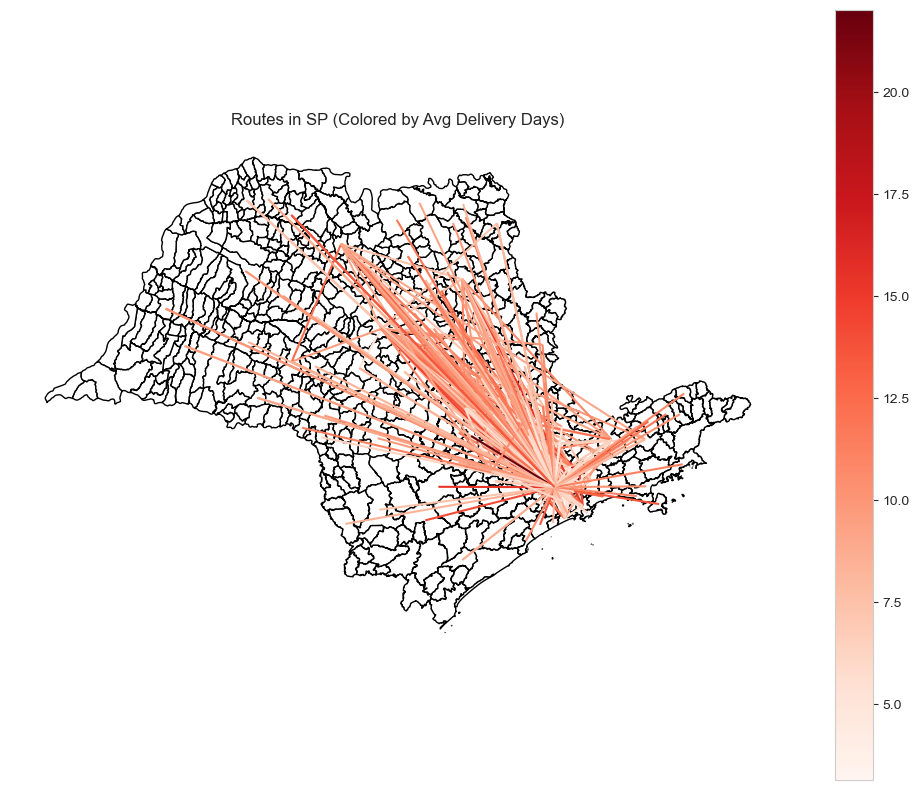

In [20]:
import matplotlib.pyplot as plt

state_poly = municipalities_gdf[municipalities_gdf['abbrev_state'] == most_popular_state].copy()


fig, ax = plt.subplots(figsize=(10,8))

# Plot the municipality polygons
state_poly.plot(ax=ax, color='white', edgecolor='black')

# Plot the routes
routes_gdf.plot(
    ax=ax,
    column='avg_delivery_days',  # or 'order_count'
    cmap='Reds',                 # color scale
    linewidth=1.5,
    legend=True
)

plt.title(f"Routes in {most_popular_state} (Colored by Avg Delivery Days)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [21]:
# Calculate Monthly Route Metrics
monthly_route_metrics = full_df.groupby(
    ['year_month','seller_code_muni','customer_code_muni'],
    as_index=False
).agg({
    'purchase_to_delivery_days': 'mean',
    'order_id': 'count'  # how many orders on that route-month
}).rename(columns={
    'purchase_to_delivery_days': 'avg_delivery_days',
    'order_id': 'order_count'
})

print("monthly_route_metrics shape:", monthly_route_metrics.shape)
monthly_route_metrics.head(5)


monthly_route_metrics shape: (62318, 5)


,year_month,seller_code_muni,customer_code_muni,avg_delivery_days,order_count
0,2016-09,4106902.0,3549409.0,54.813194,3
1,2016-10,2913606.0,2804508.0,20.558877,1
2,2016-10,3103504.0,2806909.0,22.004097,1
3,2016-10,3103504.0,3304557.0,51.996308,1
4,2016-10,3106200.0,2611606.0,11.294572,1


In [23]:
# Function to Build Route Lines for One Month
def build_monthly_route_lines(month_str, route_df, muni_centroids):
    """
    Given a month_str (e.g. '2017-08'), plus the monthly_route_metrics DataFrame
    and a code_muni -> centroid map, build a GeoDataFrame of lines for that month.
    """
    subset = route_df[route_df['year_month'] == month_str].copy()
    
    from shapely.geometry import LineString
    
    route_list = []
    for _, row in subset.iterrows():
        seller_muni = row['seller_code_muni']
        customer_muni = row['customer_code_muni']
        if pd.isna(seller_muni) or pd.isna(customer_muni):
            continue
        
        seller_centroid = muni_centroids.get(seller_muni, None)
        customer_centroid = muni_centroids.get(customer_muni, None)
        if seller_centroid is not None and customer_centroid is not None:
            line = LineString([seller_centroid, customer_centroid])
            route_list.append({
                'year_month': row['year_month'],
                'seller_code_muni': seller_muni,
                'customer_code_muni': customer_muni,
                'avg_delivery_days': row['avg_delivery_days'],
                'order_count': row['order_count'],
                'geometry': line
            })
    
    routes_gdf = gpd.GeoDataFrame(route_list, crs=municipalities_gdf.crs)
    return routes_gdf


In [24]:
def plot_routes_for_month(month_str, routes_gdf, muni_gdf, output_dir='images'):
    """
    Takes a routes GeoDataFrame for one month, plots it over all municipalities,
    and saves a PNG to 'output_dir'.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Plot all municipalities as background
    muni_gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.2)
    
    if not routes_gdf.empty:
        # Plot lines, color by avg_delivery_days
        routes_gdf.plot(
            ax=ax,
            column='avg_delivery_days',
            cmap='Reds',
            linewidth=1.2,
            legend=True
        )
        plt.title(f"Monthly Routes - {month_str} (by Avg Delivery Days)")
    else:
        plt.title(f"No routes for {month_str}")
    
    plt.axis('off')
    plt.tight_layout()
    
    filepath = os.path.join(output_dir, f"routes_{month_str}.png")
    plt.savefig(filepath, dpi=150)
    plt.close(fig)
    
    return filepath


In [25]:
# Sort months from earliest to latest
unique_months = sorted(monthly_route_metrics['year_month'].unique())
print("Unique year_month values:", unique_months)

image_files = []

for month_str in unique_months:
    # Build lines for that month
    month_routes_gdf = build_monthly_route_lines(
        month_str, monthly_route_metrics, muni_centroid_map
    )
    
    # Optional: filter out routes with low order_count or something
    month_routes_gdf = month_routes_gdf[month_routes_gdf['order_count'] > 5].copy()
    
    # Plot & save
    img_file = plot_routes_for_month(
        month_str,
        month_routes_gdf,
        municipalities_gdf,    # or a subset if you want only one state
        output_dir='images'
    )
    image_files.append(img_file)

print("Created frames:", image_files)


Unique year_month values: ['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08']
Created frames: ['images\\routes_2016-09.png', 'images\\routes_2016-10.png', 'images\\routes_2016-12.png', 'images\\routes_2017-01.png', 'images\\routes_2017-02.png', 'images\\routes_2017-03.png', 'images\\routes_2017-04.png', 'images\\routes_2017-05.png', 'images\\routes_2017-06.png', 'images\\routes_2017-07.png', 'images\\routes_2017-08.png', 'images\\routes_2017-09.png', 'images\\routes_2017-10.png', 'images\\routes_2017-11.png', 'images\\routes_2017-12.png', 'images\\routes_2018-01.png', 'images\\routes_2018-02.png', 'images\\routes_2018-03.png', 'images\\routes_2018-04.png', 'images\\routes_2018-05.png', 'images\\routes_2018-06.png', 'images\\routes_2018-07.png', 'images\\routes_2018-08.png']


In [26]:
# Combine PNGs into a GIF
gif_filename = 'animated_routes.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1.0) as writer:
    for img_path in image_files:
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"Animation saved as {gif_filename}")


C:\Users\kealankuar.wh\AppData\Local\Temp\ipykernel_21872\1595010332.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


Animation saved as animated_routes.gif
